# Model Training for Ultrasound Image Reconstruction
This notebook sets up the baseline training pipeline for U-Net using ultrasound data.  

In [90]:
import os       # file access
import matplotlib.pyplot as plt     # plotting of the results (possibly later)

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm   # for epoch iteration
from glob import glob   # for dataset preprocessing
from sklearn.model_selection import train_test_split # to perform validation on simulation data
import scipy.io as sio

############################################################################################################################
# user defined models
from models.resnet import CustomResNet      # custom resnet architecture - CNN baseline
from models.unet   import CustomUNet        # custom unet architecture - better CNN baseline
from models.effunet import EfficientUNetBeamformer  # efficientnet encoder + unet decoder - final model

# user defined scripts
from dataloader.dataset import UltrasoundDataset                # custom class to handle ultrasound RF and image data
from utils.losses import ssim_loss, mae_loss, combined_loss     # loss functions possibly interesting for US data
from utils.metrics import compute_metrics                       # function to compute SSIM and PSNR for comparisons later


## Configuration
Define all the training parameters in one variable.

In [91]:
CONFIG = {
    'model_name': 'resnet',           # options: 'resnet', 'unet', 'effunet'
    'loss_function': 'ssim',          # options: 'ssim', 'mae', 'combined'
    'batch_size': 8,
    'lr': 1e-3,
    'epochs': 150,
    'input_size': None,               # we set it based on the max depth of processed .mat files
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    'data_dir_rf': os.path.join('..', 'data', 'raw'),
    'data_dir_img': os.path.join('..', 'data', 'processed'),
}

In [92]:
def get_max_rf_depth(rf_paths):
    depths = []
    for rf_file in rf_paths:
        rf_raw = sio.loadmat(rf_file)['rf_raw']
        depths.append(rf_raw.shape[0])
    return max(depths)

rf_paths = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
CONFIG['input_size'] = (1, get_max_rf_depth(rf_paths), 128)
print(CONFIG['input_size']) # should be [1, 3328, 128]


(1, 3328, 128)


## Data Loading
We assume .mat for input RF data and .mat for the reconstructed image files.

In [93]:
import os
import numpy as np
import torch
import scipy.io as sio
from glob import glob
from tqdm import tqdm
import torch.nn.functional as F

# -------------------------------
# 1. Normalize RF frame to [-1, 1]
# -------------------------------
def normalize_rf_frame(rf):
    min_val, max_val = rf.min(), rf.max()
    if max_val - min_val > 0:
        return 2 * (rf - min_val) / (max_val - min_val) - 1
    else:
        return torch.zeros_like(rf)

# -------------------------------
# 2. Pad RF frame to fixed depth
# -------------------------------
def pad_rf_frame(rf, target_depth):
    current_depth = rf.shape[0]
    pad_len = target_depth - current_depth
    if pad_len > 0:
        return F.pad(rf, (0, 0, 0, pad_len))  # Pad along samples axis
    else:
        return rf[:target_depth, :]  # Truncate if needed

# -------------------------------
# 3. Load + process RF tensor
# -------------------------------
def load_rf_stack(rf_paths, target_depth=3328):
    rf_tensor = []

    for path in tqdm(sorted(rf_paths)):
        rf_raw = sio.loadmat(path)['rf_raw']  # [samples, 128, 75]

        for i in range(rf_raw.shape[2]):  # loop over plane waves
            rf = rf_raw[:, :, i]  # [samples, 128]
            rf = torch.tensor(rf, dtype=torch.float32)

            rf = normalize_rf_frame(rf)
            rf = pad_rf_frame(rf, target_depth)

            rf_tensor.append(rf)

    return torch.stack(rf_tensor)  # shape: [N, target_depth, 128]

In [94]:
# test rf loading
rf_paths = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
rf_tensor = load_rf_stack(rf_paths, target_depth=3328)  # Output: [450, 3328, 128]

print(len(rf_tensor))

100%|██████████| 6/6 [00:03<00:00,  1.98it/s]

450


In [95]:
import torch
import scipy.io as sio
from tqdm import tqdm

def load_img_stack(img_paths, repeats_per_img=75):
    """
    Loads and normalizes GT ultrasound images, repeating each image `repeats_per_img` times.
    
    Args:
        img_paths (list of str): Paths to .mat files containing GT images (field name: 'img').
        repeats_per_img (int): Number of times to repeat each GT image to match plane waves.

    Returns:
        torch.Tensor: Tensor of shape [num_total_images, 378, 609] in range [0, 1].
    """
    img_tensor = []

    for path in tqdm(sorted(img_paths)):
        img = sio.loadmat(path)['img']  # expected shape: [378, 609]
        img = torch.tensor(img, dtype=torch.float32) / 255.0  # normalize to [0, 1]

        # Repeat for each plane wave
        for _ in range(repeats_per_img):
            img_tensor.append(img)

    return torch.stack(img_tensor)  # final shape: [450, 378, 609]


In [96]:
rf_paths = sorted(glob(os.path.join(CONFIG['data_dir_rf'], 'rf_*.mat')))
img_paths = sorted(glob(os.path.join(CONFIG['data_dir_img'], 'img_*.mat')))

rf_tensor = load_rf_stack(rf_paths)    # [450, 3328, 128]
gt_tensor = load_img_stack(img_paths)  # [450, 378, 609]


100%|██████████| 6/6 [00:00<00:00, 83.25it/s]


In [97]:
print("RF tensor shape:", rf_tensor.shape)   # should be [450, 3328, 128]
print("GT tensor shape:", gt_tensor.shape)   # should be [450, 378, 609]


RF tensor shape: torch.Size([450, 3328, 128])
GT tensor shape: torch.Size([450, 387, 609])


In [98]:
def visualize_gt_db(gt_tensor, idx=0, clim=(-60, 0)):
    gt = gt_tensor[idx].detach().cpu().numpy()
    gt_mag = np.abs(gt)
    gt_db = 20 * np.log10(gt_mag / np.max(gt_mag) + 1e-8)

    plt.imshow(gt_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    plt.title(f"GT Image #{idx} (dB scale)")
    plt.xlabel('Lateral')
    plt.ylabel('Depth')
    plt.colorbar(label='dB')
    plt.show()

def visualize_rf_line(rf_paths, file_idx=0, pw_idx=0, ch_idx=0):
    import scipy.io as sio

    rf_raw = sio.loadmat(rf_paths[file_idx])['rf_raw']  # shape: [samples, 128, 75]

    if pw_idx >= rf_raw.shape[2]:
        raise ValueError("Invalid plane wave index")
    if ch_idx >= rf_raw.shape[1]:
        raise ValueError("Invalid transducer channel index")

    # Extract single A-line
    a_line = rf_raw[:, ch_idx, pw_idx]  # shape: [samples]
    a_line = torch.tensor(a_line, dtype=torch.float32)

    # Normalize to [-1, 1] for visualization (optional)
    min_val, max_val = a_line.min(), a_line.max()
    if max_val - min_val > 0:
        a_line = 2 * (a_line - min_val) / (max_val - min_val) - 1

    # Plot
    plt.plot(a_line.numpy())
    plt.title(f"A-line (file #{file_idx}, PW #{pw_idx}, Channel #{ch_idx})")
    plt.xlabel("Sample (depth)")
    plt.ylabel("Amplitude (normalized)")
    plt.grid(True)
    plt.show()



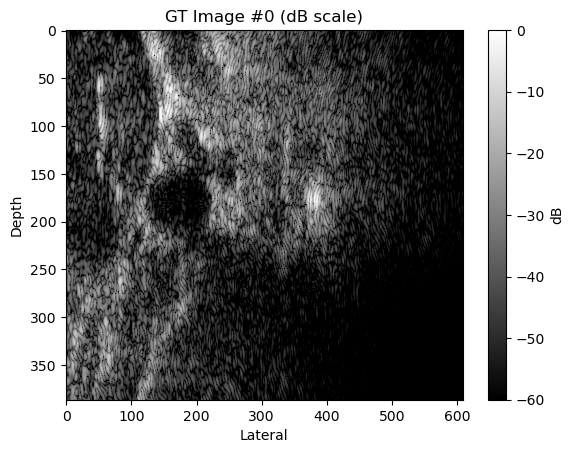

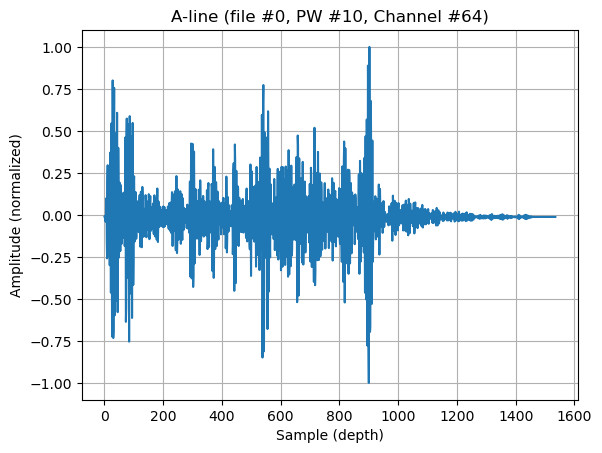

In [99]:
visualize_gt_db(gt_tensor, idx=0)
visualize_rf_line(rf_paths, file_idx=0, pw_idx=10, ch_idx=64)


In [100]:
from sklearn.model_selection import train_test_split

# Indices for splitting
indices = np.arange(rf_tensor.shape[0])
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Split tensors
rf_train, gt_train = rf_tensor[train_idx], gt_tensor[train_idx]
rf_val,   gt_val   = rf_tensor[val_idx],   gt_tensor[val_idx]
rf_test,  gt_test  = rf_tensor[test_idx],  gt_tensor[test_idx]


In [120]:
from torch.utils.data import Dataset, ConcatDataset
import torch
import random

class UltrasoundDataset(Dataset):
    def __init__(self, rf_tensor, gt_tensor, augment=False, channel_dropout=False, dropout_rate=0.1):
        self.rf_tensor = rf_tensor
        self.gt_tensor = gt_tensor
        self.augment = augment
        self.channel_dropout = channel_dropout
        self.dropout_rate = dropout_rate

    def __len__(self):
        return self.rf_tensor.shape[0]

    def __getitem__(self, idx):
        rf = self.rf_tensor[idx].clone()  # [D, 128]
        gt = self.gt_tensor[idx].unsqueeze(0).clone()  # [1, 378, 609]

        if self.channel_dropout:
            rf = self.apply_channel_dropout(rf)

        if self.augment:
            gt = self.augment_gt(gt)

        return rf, gt

    def apply_channel_dropout(self, rf):
        num_channels = rf.shape[1]
        num_drop = int(num_channels * self.dropout_rate)
        drop_indices = random.sample(range(num_channels), num_drop)
        rf[:, drop_indices] = 0
        return rf

    def augment_gt(self, gt):
    # Deterministic contrast jitter
        contrast_factor = 1.01  # Slight contrast boost
        gt = (gt - 0.5) * contrast_factor + 0.5
        gt = torch.clamp(gt, 0.0, 1.0)

        # Deterministic Gaussian noise
        noise_std = 0.001
        torch.manual_seed(42)  # Set for reproducibility (optional — or pass externally)
        noise = torch.randn_like(gt) * noise_std
        gt = gt + noise
        gt = torch.clamp(gt, 0.0, 1.0)

        return gt



In [121]:
from torch.utils.data import Dataset, ConcatDataset
# Clean training set
train_clean = UltrasoundDataset(rf_train, gt_train, augment=True, channel_dropout=False)

# Noisy training set (10% of channels randomly zeroed)
train_noisy = UltrasoundDataset(rf_train, gt_train, augment=True, channel_dropout=True)

# Combined training set
train_combined = ConcatDataset([train_clean, train_noisy])

# Validation and test sets
val_ds = UltrasoundDataset(rf_val, gt_val, augment=False, channel_dropout=False)
test_ds = UltrasoundDataset(rf_test, gt_test, augment=False, channel_dropout=False)


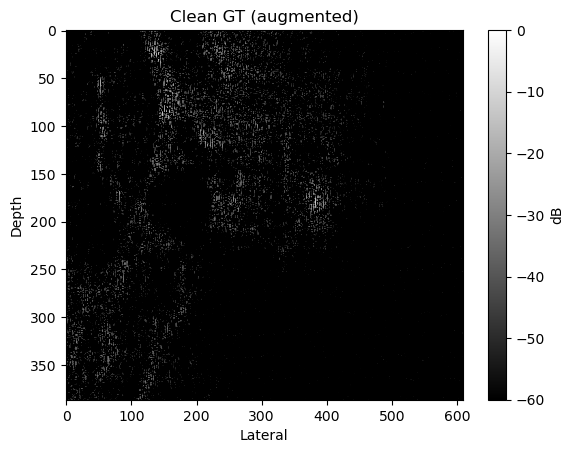

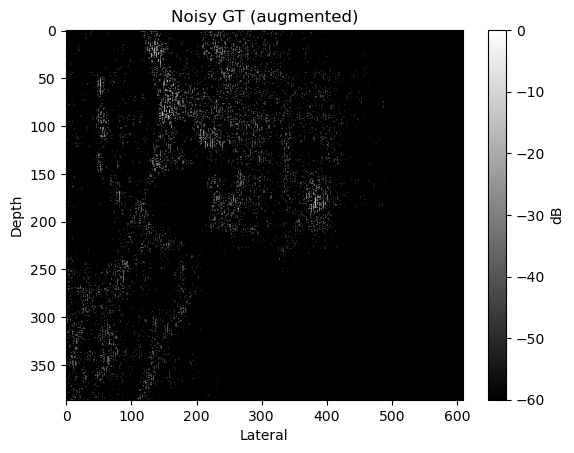

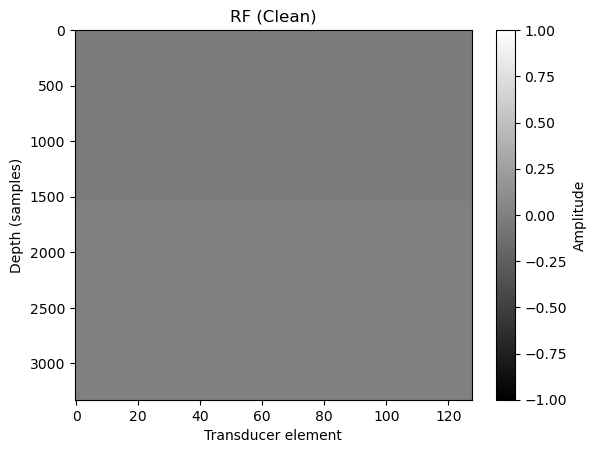

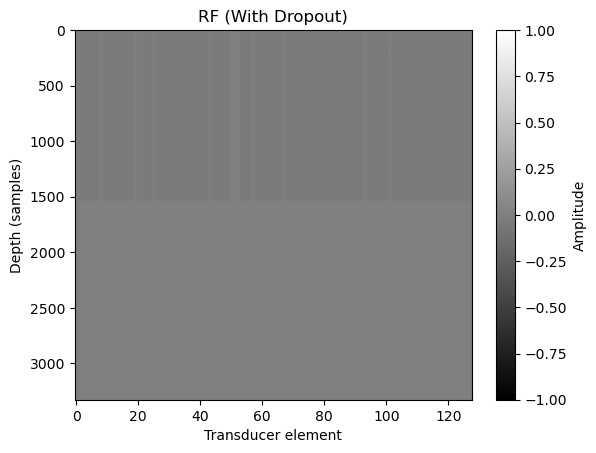

In [129]:
def visualize_gt_db_from_sample(gt_tensor, title="GT Image (dB scale)", clim=(-60, 0)):
    """
    Visualize a single GT image (tensor of shape [1, H, W] or [H, W]).
    """
    gt = gt_tensor.squeeze().detach().cpu().numpy()
    gt_mag = np.abs(gt)
    gt_db = 20 * np.log10(gt_mag / np.max(gt_mag) + 1e-8)

    plt.imshow(gt_db, cmap='gray', aspect='auto', vmin=clim[0], vmax=clim[1])
    plt.title(title)
    plt.xlabel('Lateral')
    plt.ylabel('Depth')
    plt.colorbar(label='dB')
    plt.show()

def visualize_rf_from_tensor(rf_tensor, title="RF Input"):
    """
    Visualize RF tensor [D, 128] or [1, D, 128] as a 2D image.
    """
    rf = rf_tensor.squeeze().detach().cpu().numpy()
    plt.imshow(rf, cmap='gray', aspect='auto')
    plt.title(title)
    plt.xlabel("Transducer element")
    plt.ylabel("Depth (samples)")
    plt.colorbar(label="Amplitude")
    plt.show()

idx_test = 5
rf_clean, gt_clean = train_clean[idx_test]
rf_noisy, gt_noisy = train_noisy[idx_test]

visualize_gt_db_from_sample(gt_clean, title="Clean GT (augmented)")
visualize_gt_db_from_sample(gt_noisy, title="Noisy GT (augmented)")

visualize_rf_from_tensor(rf_clean, title="RF (Clean)")
visualize_rf_from_tensor(rf_noisy, title="RF (With Dropout)")


In [87]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_combined, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)


In [88]:
# Check a single batch from each loader
train_batch = next(iter(train_loader))
val_batch   = next(iter(val_loader))
test_batch  = next(iter(test_loader))

for name, batch in zip(["Train", "Val", "Test"], [train_batch, val_batch, test_batch]):
    rf, gt = batch
    print(f"{name} RF shape: {rf.shape}, GT shape: {gt.shape}")


Train RF shape: torch.Size([8, 3328, 128]), GT shape: torch.Size([8, 1, 387, 609])
Val RF shape: torch.Size([8, 3328, 128]), GT shape: torch.Size([8, 1, 387, 609])
Test RF shape: torch.Size([8, 3328, 128]), GT shape: torch.Size([8, 1, 387, 609])


## Model Architecture
Here we define the model architecture used for training.

In [ ]:
# the idea is that we use all plane waves as input (for example 75) and then predict 1 image based on that
# TODO: change input channels when the dataset is known
if CONFIG['model_name'] == 'resnet':
    model = CustomResNet()
elif CONFIG['model_name'] == 'unet':
    model = CustomUNet()
elif CONFIG['model_name'] == 'effunet':
    model = EfficientUNetBeamformer()

In [ ]:
# we define standard optimizer and scheduler, loss is defined later based on user CONFIG
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [ ]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    epoch_loss = 0
    for x, y in tqdm(loader):
        x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
        optimizer.zero_grad()
        y_pred = model(x)

        if CONFIG['loss_function'] == 'ssim':
            loss = ssim_loss(y_pred, y)
        elif CONFIG['loss_function'] == 'mae':
            loss = mae_loss(y_pred, y)
        elif CONFIG['loss_function'] == 'combined':
            loss = combined_loss(y_pred, y)
            
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)


In [ ]:
def validate(model, loader):
    model.eval()
    val_loss = 0
    total_psnr, total_ssim = 0.0, 0.0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CONFIG['device']), y.to(CONFIG['device'])
            y_pred = model(x)
            loss = combined_loss(y_pred, y)
            val_loss += loss.item()

            # Detach and move to CPU
            preds = y_pred.detach().cpu().numpy()
            targets = y.detach().cpu().numpy()

            # Compute metrics per sample
            for i in range(preds.shape[0]):
                pred_i = preds[i, 0]  # remove channel dim: [1, H, W] → [H, W]
                target_i = targets[i, 0]

                psnr, ssim = compute_metrics(target_i, pred_i)
                total_psnr += psnr
                total_ssim += ssim

    n = len(loader.dataset)
    return (
        val_loss / len(loader),
        total_psnr / n,
        total_ssim / n
    )


## Model Training
In this part we set up the training loop, train the model and then save the parameters of the final one.

In [ ]:
# Make sure checkpoint directory exists
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)

for epoch in tqdm(range(CONFIG['epochs'])):
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_psnr, val_ssim = validate(model, val_loader)
    scheduler.step()

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"PSNR: {val_psnr:.2f} | SSIM: {val_ssim:.4f}")

    # Save checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0 or (epoch + 1) == CONFIG['epochs']:
        ckpt_path = os.path.join(CONFIG['checkpoint_dir'], f"{CONFIG['model_name']}_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'psnr': val_psnr,
            'ssim': val_ssim,
        }, ckpt_path)
        print(f"Saved checkpoint: {ckpt_path}")

In [ ]:
final_model_path = os.path.join(CONFIG['checkpoint_dir'], 'final_model.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'epoch': CONFIG['epochs'],
}, final_model_path)


## Model Visualization
We visualize one example of the reconstructed images.

In [ ]:
def show_example(model, loader):
    model.eval()
    x, y = next(iter(loader))
    x = x.to(CONFIG['device'])
    with torch.no_grad():
        y_pred = model(x).cpu()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x[0, 0].cpu(), cmap='gray')
    axs[0].set_title("Input")
    axs[1].imshow(y[0, 0], cmap='gray')
    axs[1].set_title("Target")
    axs[2].imshow(y_pred[0, 0], cmap='gray')
    axs[2].set_title("Prediction")
    plt.show()
